<u><h1>Twitter Disaster Analysis

In [3]:
import csv
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import time
from textblob import TextBlob 
import pandas as pd
import string
from collections import defaultdict
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models, similarities
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from scipy import interp
import sys
import json
from copy import deepcopy
from nltk.stem.porter import *
import nltk
import seaborn as sns
from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models, similarities
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
import re
import operator 
from nltk.corpus import stopwords
import collections
from wordcloud import WordCloud
from nltk.corpus import stopwords
#from mpl_toolkits.basemap import Basemap

In [16]:
ACCESS_TOKEN =      'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
ACCESS_SECRET =     'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
CONSUMER_KEY =      'XXXXXXXXXXXXXXXXXXXXXXXXXXX'
CONSUMER_SECRET =   'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

In [5]:
import time

# Import the necessary package to process data in JSON format
try:
    import json
except ImportError:
    import simplejson as json

# Import the necessary methods from "twitter" library
from twitter import Twitter, OAuth, TwitterHTTPError, TwitterStream

API_MAX = 100

def fetch(query, geocode = None, count = 100, filter_out_retweets = True):
    # return AT LEAST 'count' tweets
    # Note: Twitter Search API allows searching only in the past 7 days
    oauth = OAuth(ACCESS_TOKEN,ACCESS_SECRET,
                  CONSUMER_KEY,CONSUMER_SECRET)
    twitter = Twitter(auth=oauth)

    tweets = []
    next_max_id = None

    if filter_out_retweets:
        query += ' -filter:retweets'

    while len(tweets) < count:
        try:
            results = twitter.search.tweets(q=query, count=API_MAX,
                                          max_id = next_max_id, geocode = geocode)
        except Exception as e:
            print(e)
            print ('[%s] Sleeping 5 minutes...' % time.ctime())
            time.sleep(10)
            continue

        for result in results["statuses"]:
            text = result["text"].encode('utf-8').strip()
            location = result["user"]["location"].encode('utf-8').strip()
            #coordinates =result["coordinates"].encode('utf-8').strip()
            #name=result["name"].encode('utf-8').strip()
            tweet = {"timestamp" : result["created_at"],
                     "text" : text,
                     "location" : location,
                     "coordinates" : result["coordinates"],
                     "retweet" : result["retweet_count"],
                     }
            print ('[%d] %s' % (len(tweets),tweet))
            tweets.append(tweet)
            if not next_max_id:
                next_max_id = result["id"]
            else:
                next_max_id = min(result["id"], next_max_id)
        next_max_id -= 1


    return tweets

In [6]:
try:
    import json
except ImportError:
    import simplejson as json

# Import the necessary methods from "twitter" library
from twitter import Twitter, OAuth, TwitterHTTPError, TwitterStream

def print_tweet_stream(tweet_count = 100):
    # Print to screen tweets from the live stream

    oauth = OAuth(credentials.ACCESS_TOKEN, credentials.ACCESS_SECRET,
                  credentials.CONSUMER_KEY, credentials.CONSUMER_SECRET)

    # Initiate the connection to Twitter Streaming API
    twitter_stream = TwitterStream(auth=oauth)

    # Get a sample of the public data following through Twitter
    iterator = twitter_stream.statuses.sample()

    # Print each tweet in the stream to the screen
    for tweet in iterator:
        tweet_count -= 1
        # Twitter Python Tool wraps the data returned by Twitter
        # as a TwitterDictResponse object.
        # We convert it back to the JSON format to print/score
        print (json.dumps(tweet))
        #print (json.loads(tweet))

        # The command below will do pretty printing for JSON data, try it out
        # print json.dumps(tweet, indent=4)

        if tweet_count <= 0:
            break

In [7]:
def plotting():
    city=[]
    df = pd.read_csv('worldcities.csv')
    df1=pd.read_csv('disaster_tweets.csv')
    for i in (df1['location']):
        if(type(i)==str):
            city.append(i.split(',')[0])
    
    #print(city)
    # plot the blank world map
    plt.figure(figsize=(18,12))
    my_map = Basemap(projection='merc', lat_0=0, lon_0=-100,resolution = 'l', area_thresh = 5000.0,llcrnrlon=-140, llcrnrlat=-55,
                         urcrnrlon=160, urcrnrlat=70)
    # set resolution='h' for high quality 
    # draw elements onto the world map
    my_map.drawcountries()
    my_map.drawstates()
    my_map.drawmapboundary(fill_color='#3ca9fb')
    my_map.fillcontinents(color='#044372',lake_color='#3ca9fb')

    my_map.drawcoastlines(antialiased=False,linewidth=0.005)
     
    # add coordinates as red dots
    #longs = list(df.loc[(df.long != 'NaN')].long)
    latts=list(df['lat'])
    longs=list(df['lng'])
    cities=list(df['city'])
    lat=[]
    lon=[]
    for c in city:
        if c in cities:
            #print(c)
            index=cities.index(c)
            lat.append(latts[index])
            lon.append(longs[index])
    
    x, y = my_map(lon, lat)
    my_map.plot(x, y, 'ro', markersize=4, alpha=0.5)
    plt.show()
    plt.savefig('geo_location.jpg')


In [8]:
def classifier(): 
        value=0
        with open('classifier_trainset.csv', 'r') as fp:
                cl = NaiveBayesClassifier(fp, format="csv")
        with open('classifier_testset.csv','r') as f:
                value=cl.accuracy(f)*100
        print "\nAccuracy=",value,"%"
        
        relevant=0
        nt_relevant=0
       
        r=['']
        cnt=1
        print("\n=====================RELEVANT TWEETS========================\n")
        df=pd.read_csv('disaster_tweets.csv')
        for file in df["text"]:
                if(cl.classify(file.decode('utf-8'))=='Relevant'):
                        relevant+=1
                        r.append('Relevant')                        
                        print cnt,".",file,"\n"
                        cnt+=1
                else:
                        nt_relevant+=1
                        r.append('Not Relevant')
                        
       
       
        csvfile = 'disaster_tweets.csv'
        with open(csvfile, 'rb') as fin, open('new_'+csvfile, 'wb') as fout:
                reader = csv.reader(fin,  lineterminator='\n')
                writer = csv.writer(fout, lineterminator='\n')
                new_heading='Relevance'
                writer.writerow(next(reader) + [new_heading])
                i=0
                for row, val in zip(reader, r):
                        writer.writerow(row + [r[i]])
                        i=i+1
                #df.to_csv('output.csv')
        print("Relevant:",relevant)
        print("Not Relevant:",nt_relevant)


In [33]:
def barplot():    
    #word bar plot
    emoticons_str = r"""
    (?:
    [:=;] # Eyes
    [oO\-]? # Nose (optional)
    [D\)\]\(\]/\\OpP] # Mouth
    )"""
    
    regex_str = [
        emoticons_str,
        r'<[^>]+>', # HTML tags
        r'(?:@[\w_]+)', # @-mentions
        r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
        r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
     
        r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
        r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
        r'(?:[\w_]+)', # other words
        r'(?:\S)' # anything else
    ]
    
    tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)    
    
    def tokenize(s):
        return tokens_re.findall(s)    
    punctuation = list(string.punctuation)
    
    stop = stopwords.words('english') + punctuation + ['rt', 'via']
    
    def preprocess(s, lowercase=False):
        tokens = tokenize(s)
        if lowercase:
            tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
        return tokens
    
    df = pd.read_csv("disaster_tweets.csv",error_bad_lines=False)
    print (df.columns)
    count_all = Counter()
    df = df[["text"]]
    print ("Total tweets: %d" % len(df))
    df = df.drop_duplicates(subset = ["text"]).reset_index() #this also resets the index otherwise the numbers will have gaps
    print ("Total unique tweets: %d" % len(df))
    word_counter = {}
    
    for i in df["text"]:           
            terms_stop =[terms for terms in preprocess(i) if terms not in stop]
            #print(terms_stop)
            for word in terms_stop:
                    if (word in word_counter) and (len(word)>3):
                            word_counter[word]+=1
                    else:
                            word_counter[word]=1
    popular_words= sorted(word_counter.items(), key=operator.itemgetter(1),reverse=True)
    top= popular_words[:10]
    print(top)
    
    Words = list(zip(*top))[0]
    Count = list(zip(*top))[1]
    x_pos = np.arange(len(Words)) 
    
    # calculate slope and intercept for the linear trend line
    slope, intercept = np.polyfit(x_pos, Count, 1)
    trendline = intercept + (slope * x_pos)
    plt.figure(figsize=(10,8))
    plt.plot(x_pos, trendline, color='red', linestyle='--')    
    plt.bar(x_pos, Count,align='center')
    plt.xticks(x_pos, Words,rotation=90) 
    plt.ylabel('Count')
    plt.show()
    plt.savefig('barplot.jpg')

In [37]:
def wordcloud():
    train = pd.read_csv("disaster_tweets.csv")
    train.head()
    
    def remove_pattern(input_txt, pattern):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)        
        return input_txt 

    train['tidy_tweet'] = np.vectorize(remove_pattern)(train['text'], "@[\w]*")
    train['tidy_tweet'] = train['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
    train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
    train.head()

    tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split())
    tokenized_tweet.head()
    stemmer = PorterStemmer()
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
    tokenized_tweet.head()
         
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        train['tidy_tweet'] = tokenized_tweet
    
    all_words = ' '.join([text for text in train['tidy_tweet']])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    plt.savefig('wordcloud.jpg')

In [13]:
T = TweetTokenizer()
print("=========================================================================")
print("=========================================================================")
print("==============  TWITTER ANALYSIS FOR DISASTER MANAGEMENT  ===============")
print("=========================================================================")
print("=========================================================================")

x=input("Enter the lattitude value:")
y=input("Enter the longitude value:")
r=input("Enter the range (Eg: 20) :")
#BOSTON_GEOCODE = "42.362393,-71.062971,10km"
#CHICAGO_GEOCODE = "41.881832,-87.623177,10km"
#HOUSTON_TEXAS_GEOCODE = "29.789054,-95.387083,10km"
#MEXICO_CITY_GEOCODE = "19.432608,-99.133209,10km"
#Mumbai_GEOCODE = "19.075984,72.877656,10km"
#NewYork_Geocode="40.712775,-74.005973,20km"
geocode=str(x)+","+str(y)+","+str(r)+"km"

keyword=[]
num=int(input("Enter number of keywords:"))
for i in range(0, num): # set up loop to run 5 times
	k = input('Please Enter Keyword :')
	keyword.append(k) # append to our_list

count=int(input("Enter the number of tweets u want to search:"))

==============  TWITTER ANALYSIS FOR DISASTER MANAGEMENT  ===============
Enter the lattitude value:40.71
Enter the longitude value:-74.15
Enter the range (Eg: 20) :4000
Enter number of keywords:1
Please Enter Keyword :'cyclone'
Enter the number of tweets u want to search:2500


In [17]:
if __name__ == '__main__':
    with open("disaster_tweets.csv", 'w') as csvfile:
        fieldnames = ['timestamp', 'location', 'text', 'coordinates', 'retweet']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for kw in keyword:
            tweets = fetch(kw,geocode=geocode, count=count)
            yp=[]
            ys=[]
            for t in tweets:
                analysis = TextBlob(t.get('text').decode('utf-8'))
                yp.append(analysis.sentiment.polarity)
                ys.append(analysis.sentiment.subjectivity)
                writer.writerow(t)

[0] {'retweet': 0, 'timestamp': u'Sat Oct 20 11:24:54 +0000 2018', 'location': 'Nashville, TN', 'coordinates': None, 'text': '@AllTogetherNows @KNP2BP @POTUS Really\xe2\x80\x94would you want people who break down anything in their way to get what they\xe2\x80\xa6 https://t.co/TvwSWqvbQ2'}
[1] {'retweet': 0, 'timestamp': u'Sat Oct 20 10:35:03 +0000 2018', 'location': 'Stamford, CT USA', 'coordinates': None, 'text': 'Green alert for tropical cyclone TWENTY-FOUR-E-18. Population affected by Category 1 (120 km/h) wind speeds or\xe2\x80\xa6'}
[2] {'retweet': 0, 'timestamp': u'Sat Oct 20 10:00:48 +0000 2018', 'location': 'US', 'coordinates': None, 'text': 'CYCO Cyclone Rooting Gel Sachet 10 mL (10/Cs) \n$6.60\n\xe2\x9e\xa4 https://t.co/PX7NUHcGeb https://t.co/gIwjEv7RvV'}
[3] {'retweet': 0, 'timestamp': u'Sat Oct 20 09:55:39 +0000 2018', 'location': 'Sacramento, CA', 'coordinates': None, 'text': '@JLJeffLewis @Bravotv Flipping Out is the only acting job @Jennipulos will ever get.'}
[4] {'ret

[100] {'retweet': 0, 'timestamp': u'Sat Oct 20 00:32:50 +0000 2018', 'location': 'Dover, DE', 'coordinates': None, 'text': 'The Cyclone#31: The Bad News Browns: https://t.co/ZcD4uCfLEo via @YouTube'}
[101] {'retweet': 0, 'timestamp': u'Sat Oct 20 00:32:31 +0000 2018', 'location': 'Dover, DE', 'coordinates': None, 'text': "The Cyclone#32: Let's Talk Week 5: https://t.co/eVZB3cyIsq via @YouTube"}
[102] {'retweet': 0, 'timestamp': u'Sat Oct 20 00:27:40 +0000 2018', 'location': 'Dover, DE', 'coordinates': None, 'text': 'I uploaded a new episode, "The Cyclone#32: Let\'s Talk Week 5", on #spreaker https://t.co/UVwy7mU8Bb'}
[103] {'retweet': 0, 'timestamp': u'Sat Oct 20 00:27:31 +0000 2018', 'location': 'Dover, DE', 'coordinates': None, 'text': 'I uploaded a new episode, "The Cyclone#31: The Bad News Browns", on #spreaker https://t.co/1TN7S98rt1'}
[104] {'retweet': 0, 'timestamp': u'Sat Oct 20 00:26:26 +0000 2018', 'location': 'Dover, DE', 'coordinates': None, 'text': "The Cyclone#32: Let's T

[200] {'retweet': 3, 'timestamp': u'Fri Oct 19 16:10:26 +0000 2018', 'location': 'san diego', 'coordinates': None, 'text': 'baby bash and t-pain didn\xe2\x80\x99t have to go so hard when they made cyclone but they DID'}
[201] {'retweet': 0, 'timestamp': u'Fri Oct 19 16:02:20 +0000 2018', 'location': 'Des Moines, IA', 'coordinates': None, 'text': '@billfrein64 @pricej7481 @KXnOMorningRush @Sean23Roberts I hope @jprice7481 is kidding. This week alone Travis has\xe2\x80\xa6 https://t.co/k6Yxb6hupt'}
[202] {'retweet': 2, 'timestamp': u'Fri Oct 19 15:35:44 +0000 2018', 'location': 'United States', 'coordinates': None, 'text': 'A great example which goes to show how #HurricaneMichael joins the club of storms which illustrate the fact that ra\xe2\x80\xa6 https://t.co/ls5Kv85zXe'}
[203] {'retweet': 0, 'timestamp': u'Fri Oct 19 15:35:07 +0000 2018', 'location': 'Warren, MI', 'coordinates': None, 'text': '@VikkiKitty_ Twix right there'}
[204] {'retweet': 0, 'timestamp': u'Fri Oct 19 15:32:17 +00

[300] {'retweet': 0, 'timestamp': u'Fri Oct 19 02:54:16 +0000 2018', 'location': 'in the pines', 'coordinates': None, 'text': '@jamiattenberg @darth @molly_knight THAT BALEFUL STARE! I love him'}
[301] {'retweet': 0, 'timestamp': u'Fri Oct 19 02:50:24 +0000 2018', 'location': '414', 'coordinates': None, 'text': '@devlightyear @BabyBash Suga Suga is for sure a banger, but Cyclone had you going crazy at all the dances freshman year of high school.'}
[302] {'retweet': 1, 'timestamp': u'Fri Oct 19 02:50:17 +0000 2018', 'location': 'Illinois, USA', 'coordinates': None, 'text': 'Lets fucking go first quad head ever and first banger on this game https://t.co/636v6ghcLM'}
[303] {'retweet': 0, 'timestamp': u'Fri Oct 19 02:48:23 +0000 2018', 'location': 'Milwaukee, WI', 'coordinates': None, 'text': '@A_Payne93 @BabyBash Suga Suga is 10x the song Cyclone could ever dream of being. I don\xe2\x80\x99t even want to hear the \xe2\x80\x9cdi\xe2\x80\xa6 https://t.co/162xrHOC5n'}
[304] {'retweet': 0, 't

[400] {'retweet': 0, 'timestamp': u'Thu Oct 18 18:34:04 +0000 2018', 'location': 'Arizona, USA', 'coordinates': None, 'text': 'People are so fucking sick wtf is wrong with people. This pisses me off https://t.co/fNtJGTKhQE'}
[401] {'retweet': 0, 'timestamp': u'Thu Oct 18 18:26:03 +0000 2018', 'location': 'Huntsville, AL,USA', 'coordinates': None, 'text': '@MBharat23058214 @ashok_dammu You dont have to spend lot of money to celebrate great festival. Adults are okay? But\xe2\x80\xa6 https://t.co/fV30MM3Vyu'}
[402] {'retweet': 0, 'timestamp': u'Thu Oct 18 18:23:34 +0000 2018', 'location': 'Iowa, USA', 'coordinates': None, 'text': "If a you, a fan, needs big-name non-con opponents to get excited about Cyclone football, you're the problem, and you are few."}
[403] {'retweet': 0, 'timestamp': u'Thu Oct 18 18:10:08 +0000 2018', 'location': 'Los Angeles, CA', 'coordinates': None, 'text': "Starting this week, in a new column titled IS DEAD BETTER, I'll be checking out an older #horror film I've

[500] {'retweet': 0, 'timestamp': u'Thu Oct 18 04:46:08 +0000 2018', 'location': 'Arizona, USA', 'coordinates': None, 'text': '@LegendGoCrazy1 Drake is'}
[501] {'retweet': 0, 'timestamp': u'Thu Oct 18 04:46:04 +0000 2018', 'location': 'Arizona, USA', 'coordinates': None, 'text': '@LegendGoCrazy1 Stfu'}
[502] {'retweet': 0, 'timestamp': u'Thu Oct 18 04:42:09 +0000 2018', 'location': 'Arizona, USA', 'coordinates': None, 'text': 'If booker takes over I change avi to drake wearing booker high school jersey'}
[503] {'retweet': 0, 'timestamp': u'Thu Oct 18 04:40:10 +0000 2018', 'location': 'Arizona, USA', 'coordinates': None, 'text': '@LegendGoCrazy1 Who are you rooting for'}
[504] {'retweet': 0, 'timestamp': u'Thu Oct 18 04:39:18 +0000 2018', 'location': 'Arizona, USA', 'coordinates': None, 'text': 'BOOOOKEEERRRR'}
[505] {'retweet': 0, 'timestamp': u'Thu Oct 18 04:22:15 +0000 2018', 'location': 'Washington, DC', 'coordinates': None, 'text': "A Midterm Wave? Maybe It's a 'Cyclone' https://t.

[600] {'retweet': 0, 'timestamp': u'Wed Oct 17 22:09:22 +0000 2018', 'location': 'Grand Island', 'coordinates': None, 'text': '"On Politics With Lisa Lerer: A Midterm Wave? Maybe It\xe2\x80\x99s a \xe2\x80\x98Cyclone\xe2\x80\x99" by LISA LERER via NYT https://t.co/eeQnnhAkYM'}
[601] {'retweet': 0, 'timestamp': u'Wed Oct 17 22:09:17 +0000 2018', 'location': 'Cooperstown', 'coordinates': None, 'text': '"On Politics With Lisa Lerer: A Midterm Wave? Maybe It\xe2\x80\x99s a \xe2\x80\x98Cyclone\xe2\x80\x99" by LISA LERER via NYT https://t.co/vDbDIMHOZ2'}
[602] {'retweet': 0, 'timestamp': u'Wed Oct 17 22:09:16 +0000 2018', 'location': 'Coppell', 'coordinates': None, 'text': '"On Politics With Lisa Lerer: A Midterm Wave? Maybe It\xe2\x80\x99s a \xe2\x80\x98Cyclone\xe2\x80\x99" by LISA LERER via NYT https://t.co/v68KwlaE7A'}
[603] {'retweet': 0, 'timestamp': u'Wed Oct 17 22:08:30 +0000 2018', 'location': 'Flynn', 'coordinates': None, 'text': '"On Politics With Lisa Lerer: A Midterm Wave? Maybe 

[700] {'retweet': 0, 'timestamp': u'Wed Oct 17 15:17:32 +0000 2018', 'location': 'Pittsburgh, PA', 'coordinates': None, 'text': 'Tropical Cyclone Titli Kills Dozens in Eastern India | The Weather Channel https://t.co/Zz2LP6FGYn #SmartNews'}
[701] {'retweet': 0, 'timestamp': u'Wed Oct 17 15:00:02 +0000 2018', 'location': 'NC', 'coordinates': None, 'text': 'Littlest Pet Shop Fairies Cherry Cyclone 3071 Light up glow #fairy #LPS https://t.co/PDm55qvK05 https://t.co/ShyiXwksQT #toy #figure'}
[702] {'retweet': 0, 'timestamp': u'Wed Oct 17 14:57:33 +0000 2018', 'location': 'Michigan, USA', 'coordinates': None, 'text': 'https://t.co/vAPFT9pwAo'}
[703] {'retweet': 0, 'timestamp': u'Wed Oct 17 14:43:35 +0000 2018', 'location': 'USA', 'coordinates': None, 'text': 'Cut your cannabis processing time in half with the Fritsch Pulverisette 19! https://t.co/97p4QukCpf\nThe Fritsch mil\xe2\x80\xa6 https://t.co/9mKTay49G7'}
[704] {'retweet': 0, 'timestamp': u'Wed Oct 17 14:27:56 +0000 2018', 'location':

[800] {'retweet': 0, 'timestamp': u'Tue Oct 16 21:13:09 +0000 2018', 'location': 'Norwalk, IA', 'coordinates': None, 'text': '@ChrisMWilliams @Murph_Andy here\xe2\x80\x99s my idea.  I will start a go fund me account and everyone contribute $1.  We pass\xe2\x80\xa6 https://t.co/1CiU7qZpeg'}
[801] {'retweet': 0, 'timestamp': u'Tue Oct 16 21:09:45 +0000 2018', 'location': 'Baton Rouge, LA', 'coordinates': None, 'text': 'Tropical Cyclone Luban made landfall in Yemen near the border with Oman, bringing a year\xe2\x80\x99s worth of rainfall to Oma\xe2\x80\xa6 https://t.co/adel107gQX'}
[802] {'retweet': 3, 'timestamp': u'Tue Oct 16 21:03:37 +0000 2018', 'location': 'Des Moines, Iowa.', 'coordinates': None, 'text': 'Big 12 fines Iowa State for field storm. Iowa State plans to appeal it. https://t.co/IYInwuUVZn'}
[803] {'retweet': 0, 'timestamp': u'Tue Oct 16 21:01:12 +0000 2018', 'location': 'Cambridge, IA', 'coordinates': None, 'text': 'I don\xe2\x80\x99t speak for every cyclone fan, but I li

[900] {'retweet': 0, 'timestamp': u'Tue Oct 16 11:00:45 +0000 2018', 'location': 'Rockaway, NJ', 'coordinates': None, 'text': 'Trivia Tuesday time!!!\n\nWho built the Cyclone Spoiler muscle car....? \n\nA. Ford\nB. Mercury\nC. GMC\nD. Plymouth'}
[901] {'retweet': 0, 'timestamp': u'Tue Oct 16 10:56:38 +0000 2018', 'location': 'Detroit, MI', 'coordinates': None, 'text': '@ItsMeCyclone Sorry cyclone but u said u would\nA promise is a promise'}
[902] {'retweet': 1, 'timestamp': u'Tue Oct 16 10:50:59 +0000 2018', 'location': 'USA', 'coordinates': None, 'text': '#Tollywood celebrities pitch in to help the victims of #CycloneTitli.\nRead the full story here:\xe2\x80\xa6 https://t.co/ki1pPtPYDK'}
[903] {'retweet': 0, 'timestamp': u'Tue Oct 16 10:20:07 +0000 2018', 'location': 'Omaha, Nebraska', 'coordinates': None, 'text': '@martensjf I\xe2\x80\x99d say that about the typical Cyclone QB in the NFL, but I don\xe2\x80\x99t think there\xe2\x80\x99s even been one \xf0\x9f\x98\x82\xf0\x9f\x98\x82'}

[1000] {'retweet': 0, 'timestamp': u'Mon Oct 15 20:55:33 +0000 2018', 'location': 'Houston, TX', 'coordinates': None, 'text': '@stefanieGMJ @mggyy @haileybaldwin @bellahadid @GiGiHadid @theirishayk @taylorswift13 @selenagomez @emrata\xe2\x80\xa6 https://t.co/6ykHYlqeYf'}
[1001] {'retweet': 0, 'timestamp': u'Mon Oct 15 20:50:18 +0000 2018', 'location': 'Martinique', 'coordinates': None, 'text': "Si le d\xc3\xa9r\xc3\xa8glement climatique est un r\xc3\xa9chauffement celaveut dire tr\xc3\xa8s probablement plus d'air sec\n\nEt donc m\xc3\xa9caniquement moins de cyclone"}
[1002] {'retweet': 0, 'timestamp': u'Mon Oct 15 20:47:13 +0000 2018', 'location': 'Florida, USA', 'coordinates': None, 'text': 'Cyclone Leslie slams into Portugal, leaves 27 injured\n\xf0\x9f\x8c\x80  #CycloneLeslie #HurricaneLeslie #TropicalStormLeslie #Wx\xe2\x80\xa6 https://t.co/hQrcIv6WEx'}
[1003] {'retweet': 0, 'timestamp': u'Mon Oct 15 20:38:18 +0000 2018', 'location': 'Wilmington, NC', 'coordinates': None, 'text': '

[1100] {'retweet': 0, 'timestamp': u'Mon Oct 15 14:23:47 +0000 2018', 'location': 'Nashville, TN', 'coordinates': None, 'text': 'Hurricane Leslie (post-tropical cyclone) path, track: Portugal landfall, Spain impact predicted in rare strike https://t.co/ScQx7BFLme'}
[1101] {'retweet': 1, 'timestamp': u'Mon Oct 15 14:23:27 +0000 2018', 'location': 'Warren, MI', 'coordinates': None, 'text': '@shofu EatDatPussy445'}
[1102] {'retweet': 3, 'timestamp': u'Mon Oct 15 14:15:40 +0000 2018', 'location': 'Bellefonte, PA', 'coordinates': None, 'text': 'Moisture from former cyclone #Luban, mainly in the form of scattered mid and high clouds, being flung as far northe\xe2\x80\xa6 https://t.co/NiiuKxJMhn'}
[1103] {'retweet': 0, 'timestamp': u'Mon Oct 15 14:15:38 +0000 2018', 'location': 'Los Angeles, California, USA', 'coordinates': None, 'text': 'Cyclone Leslie slams into Portugal https://t.co/ahCozrphLt https://t.co/eQ5yCPIcfK'}
[1104] {'retweet': 0, 'timestamp': u'Mon Oct 15 14:13:29 +0000 2018', '

[1200] {'retweet': 0, 'timestamp': u'Mon Oct 15 01:04:30 +0000 2018', 'location': 'Ankeny, IA', 'coordinates': None, 'text': '"Save" rushing the field?  Do we only get one per season?  It\'s fun.  Rush the field all you want Cyclone fans. https://t.co/Gp89CDncly'}
[1201] {'retweet': 0, 'timestamp': u'Mon Oct 15 01:03:57 +0000 2018', 'location': 'Nevada, IA', 'coordinates': None, 'text': 'I think if Iowa and Iowa State were in the same conference together, Cyclone fans would care more about the game. W\xe2\x80\xa6 https://t.co/mLaQ2AzlRm'}
[1202] {'retweet': 6, 'timestamp': u'Mon Oct 15 00:49:21 +0000 2018', 'location': 'Davenport, IA', 'coordinates': None, 'text': 'Excited to have recent #Cyclone wrestling commit @jbiii_13 into the @ESPN935 studios on Monday &amp; on the air at 12:4\xe2\x80\xa6 https://t.co/PrD9YanxqQ'}
[1203] {'retweet': 0, 'timestamp': u'Mon Oct 15 00:45:35 +0000 2018', 'location': 'Toronto, Canada', 'coordinates': None, 'text': '@georgeegirl @DiamondLynne1 @Briandit

[1300] {'retweet': 0, 'timestamp': u'Sun Oct 14 19:22:23 +0000 2018', 'location': '', 'coordinates': None, 'text': '@JeniferEDillard @Joey_Ramos76 My wife and I both went to ISU. Our daughter is at Deer Valley and we\xe2\x80\x99re taking her\xe2\x80\xa6 https://t.co/0o4O8LCrUZ'}
[1301] {'retweet': 0, 'timestamp': u'Sun Oct 14 19:13:03 +0000 2018', 'location': 'Virginia, USA', 'coordinates': None, 'text': '@ITz_Cyclone @SanJoseSharks Not jones fault it\xe2\x80\x99s everybody\xe2\x80\x99s fault for letting Dea get behind our defense!!!! And putting the puck home!!!!!'}
[1302] {'retweet': 0, 'timestamp': u'Sun Oct 14 19:12:32 +0000 2018', 'location': 'Ames, Iowa', 'coordinates': None, 'text': 'CYCLONE GOAL! #WhateverItTakes #CycloneHockey'}
[1303] {'retweet': 0, 'timestamp': u'Sun Oct 14 19:09:03 +0000 2018', 'location': 'Earth', 'coordinates': None, 'text': 'Storm Leslie leaves at least 300000 homes without power as it hits Portugal https://t.co/nXDXlnKePR https://t.co/CKES0uTXML'}
[1304

[1400] {'retweet': 0, 'timestamp': u'Sun Oct 14 14:47:53 +0000 2018', 'location': 'El Dorado Hills, CA', 'coordinates': None, 'text': '@desean282 https://t.co/FmskR8X5UV'}
[1401] {'retweet': 0, 'timestamp': u'Sun Oct 14 14:47:49 +0000 2018', 'location': 'mars', 'coordinates': None, 'text': 'Gadkari says on tv bjp dint expect to win 2014 elections,  thrfr giving out false promises... This implies bjp r li\xe2\x80\xa6 https://t.co/zZ6vWjdVdb'}
[1402] {'retweet': 2, 'timestamp': u'Sun Oct 14 14:44:35 +0000 2018', 'location': 'Des Moines, Iowa', 'coordinates': None, 'text': "Almost as awesome as last night's Cyclone victory. https://t.co/EcLoRaTM0y"}
[1403] {'retweet': 0, 'timestamp': u'Sun Oct 14 14:44:30 +0000 2018', 'location': 'USA', 'coordinates': None, 'text': 'Cyclone #Leslie slams into #Portugal, leaves 27 injured - Oct 14 @ 10:43 AM ET  https://t.co/Sr4P0Ql1Ev'}
[1404] {'retweet': 0, 'timestamp': u'Sun Oct 14 14:35:44 +0000 2018', 'location': 'EUROPA', 'coordinates': None, 'text':

[1500] {'retweet': 0, 'timestamp': u'Sun Oct 14 06:04:11 +0000 2018', 'location': 'Central Iowa', 'coordinates': None, 'text': '@CFBONFOX @CycloneFB Woohoo!!!  So proud to be a #Cyclone.'}
[1501] {'retweet': 0, 'timestamp': u'Sun Oct 14 06:02:38 +0000 2018', 'location': 'Des Moines, IA', 'coordinates': None, 'text': 'Thankful for my lifelong best friend, and thrilling Cyclone Wins! Both of the Walton kids made it onto the field at\xe2\x80\xa6 https://t.co/SEEe7J9sZx'}
[1502] {'retweet': 0, 'timestamp': u'Sun Oct 14 06:01:32 +0000 2018', 'location': 'Illinois, USA', 'coordinates': None, 'text': '@DareMethy i\xe2\x80\x99ve only hit a 1 frame quad feed and a semi spraying triple headshot feed lmao'}
[1503] {'retweet': 0, 'timestamp': u'Sun Oct 14 05:47:49 +0000 2018', 'location': 'Davenport, IA', 'coordinates': None, 'text': 'Lots of Cyclone pride on wide display at Jack Trice stadium in Ames, Iowa #CyclONEnation https://t.co/U143d6euo3'}
[1504] {'retweet': 0, 'timestamp': u'Sun Oct 14 05

[1600] {'retweet': 0, 'timestamp': u'Sun Oct 14 02:52:25 +0000 2018', 'location': 'Ankeny, IA', 'coordinates': None, 'text': 'Cyclone defense just shut down #6 team in the country... without Ray Lima.  Unbelievable. #cyclONEnation'}
[1601] {'retweet': 0, 'timestamp': u'Sun Oct 14 02:50:47 +0000 2018', 'location': 'EUROPA', 'coordinates': None, 'text': 'Hurricane Leslie (Post-Tropical Cyclone) Path, Track: Portugal Landfall, Spain Impact Predicted in R... https://t.co/qCV2U3VUm0'}
[1602] {'retweet': 2, 'timestamp': u'Sun Oct 14 02:49:07 +0000 2018', 'location': 'Iowa State Athletics', 'coordinates': {u'type': u'Point', u'coordinates': [-93.63590983, 42.01403958]}, 'text': 'Thanks to all the Cyclone Club members who came out to cheer on the Cyclones. Here\xe2\x80\x99s to a great win and great fans!\xe2\x80\xa6 https://t.co/6bs4DtobvY'}
[1603] {'retweet': 0, 'timestamp': u'Sun Oct 14 02:48:33 +0000 2018', 'location': 'Grimes, IA', 'coordinates': None, 'text': 'Great night to be a Cyclone!

[1700] {'retweet': 0, 'timestamp': u'Sun Oct 14 02:01:18 +0000 2018', 'location': '', 'coordinates': None, 'text': '@RedDirtSport watching Grier\xe2\x80\x99s Heisman hopes get blown away by a cyclone!'}
[1701] {'retweet': 0, 'timestamp': u'Sun Oct 14 02:00:50 +0000 2018', 'location': 'Ames, IA', 'coordinates': None, 'text': 'Cyclone Power! @Dan_Robson23'}
[1702] {'retweet': 0, 'timestamp': u'Sun Oct 14 02:00:20 +0000 2018', 'location': 'Ames, Iowa', 'coordinates': None, 'text': "D'Andre Payne INT for Iowa State.  Cyclone ball at their own 45.  ISU 28, WVU 14; 10:54 4th qtr."}
[1703] {'retweet': 0, 'timestamp': u'Sun Oct 14 01:59:38 +0000 2018', 'location': 'Florida', 'coordinates': None, 'text': "@Cyclone_151 This is gonna sound like a cop out so I'm sorry. That being said I actually don't like the idea of an\xe2\x80\xa6 https://t.co/pZsHOtErrz"}
[1704] {'retweet': 0, 'timestamp': u'Sun Oct 14 01:59:36 +0000 2018', 'location': 'Denver, CO', 'coordinates': None, 'text': 'West Virginia j

[1800] {'retweet': 0, 'timestamp': u'Sat Oct 13 23:08:54 +0000 2018', 'location': 'Texas', 'coordinates': None, 'text': '@DRmetwatch @pppapin @Cyclonebiskit I propose a new classification:  PPTC. This acronym could be used interchangeab\xe2\x80\xa6 https://t.co/lq0j11fGNu'}
[1801] {'retweet': 1, 'timestamp': u'Sat Oct 13 22:57:24 +0000 2018', 'location': 'Cheat Lake, WV', 'coordinates': None, 'text': 'Siri what is a Cyclone bird?'}
[1802] {'retweet': 0, 'timestamp': u'Sat Oct 13 22:53:53 +0000 2018', 'location': 'Iowa', 'coordinates': None, 'text': '@bigbirdpurdy Enjoy the game, hope it\xe2\x80\x99s a Cyclone WIN!'}
[1803] {'retweet': 0, 'timestamp': u'Sat Oct 13 22:53:28 +0000 2018', 'location': 'Iowa, USA', 'coordinates': None, 'text': '@CooterRayCorn https://t.co/w1DEHmWF9k'}
[1804] {'retweet': 0, 'timestamp': u'Sat Oct 13 22:53:08 +0000 2018', 'location': 'United States', 'coordinates': None, 'text': '@TheWeatherMastr I would change PTC Leslie to lol post TC. Because at first I tho

[1900] {'retweet': 0, 'timestamp': u'Sat Oct 13 17:45:50 +0000 2018', 'location': 'El Caribe', 'coordinates': None, 'text': 'Tormenta en el Atl\xc3\xa1ntico: Summary for Post-Tropical Cyclone Leslie (AT3/AL132018) m\xc3\xa1s en: https://t.co/JMMLXSamOX'}
[1901] {'retweet': 0, 'timestamp': u'Sat Oct 13 17:45:50 +0000 2018', 'location': 'El Caribe', 'coordinates': None, 'text': 'Tormenta en el Atl\xc3\xa1ntico: Post-Tropical Cyclone Leslie Update Statement m\xc3\xa1s en: https://t.co/oPBuywTQsz'}
[1902] {'retweet': 0, 'timestamp': u'Sat Oct 13 17:45:49 +0000 2018', 'location': 'El Caribe', 'coordinates': None, 'text': 'Tormenta en el Atl\xc3\xa1ntico: Post-Tropical Cyclone Leslie Graphics m\xc3\xa1s en: https://t.co/IYdqtk1NtT'}
[1903] {'retweet': 1, 'timestamp': u'Sat Oct 13 17:44:31 +0000 2018', 'location': 'Staten Island, NY', 'coordinates': None, 'text': '2PM UPDATE: #Leslie is now a post-tropical cyclone. She will make landfall in Portugal soon. Still speeding along a\xe2\x80\xa6 ht

[2000] {'retweet': 11, 'timestamp': u'Sat Oct 13 12:12:30 +0000 2018', 'location': 'Toronto', 'coordinates': None, 'text': '12 feared dead in landslide that swamped a shelter in eastern India where villagers were taking refuge to escape se\xe2\x80\xa6 https://t.co/5GKs60brBE'}
[2001] {'retweet': 2, 'timestamp': u'Sat Oct 13 12:11:24 +0000 2018', 'location': 'Canada', 'coordinates': None, 'text': '12 feared dead in India cyclone shelter swamped by landslide https://t.co/X2KJVtUwxP https://t.co/CjOCJ7ml9O'}
[2002] {'retweet': 0, 'timestamp': u'Sat Oct 13 12:11:16 +0000 2018', 'location': 'North Liberty, IA', 'coordinates': None, 'text': 'Former Cyclone Nick Voke has been killing it lately in China. He\xe2\x80\x99s finished 4th, 1st\xf0\x9f\x8f\x86, and 3rd in his last three.\xe2\x80\xa6 https://t.co/a7pwUEW5LZ'}
[2003] {'retweet': 0, 'timestamp': u'Sat Oct 13 12:05:28 +0000 2018', 'location': 'Ireland', 'coordinates': None, 'text': '12 feared dead in India cyclone shelter swamped by land

[2100] {'retweet': 4, 'timestamp': u'Sat Oct 13 00:31:45 +0000 2018', 'location': 'Chester, SC', 'coordinates': None, 'text': 'Canden settles for a 43 yard FG attempt that hit a Cyclone on the ankle. Chester ball, up 13-7, 15 seconds until Ralf time.'}
[2101] {'retweet': 0, 'timestamp': u'Sat Oct 13 00:29:55 +0000 2018', 'location': 'Fort Worth, TX', 'coordinates': None, 'text': 'Oil companies asked to supply essential commodities in cyclone-hit Odisha  https://t.co/EKJbp9lrUE'}
[2102] {'retweet': 0, 'timestamp': u'Sat Oct 13 00:23:53 +0000 2018', 'location': 'West Des Moines, IA', 'coordinates': None, 'text': "Tiger's force another Ames punt. Will start with the ball on the Ames 40 yard line.  McCuddin's sack ended the little cyclone possession."}
[2103] {'retweet': 0, 'timestamp': u'Sat Oct 13 00:21:34 +0000 2018', 'location': 'Castalia, Ohio', 'coordinates': None, 'text': 'If I\xe2\x80\x99m being honest.... there\xe2\x80\x99s never a bad time to play Cyclone by Baby Bash'}
[2104] {'

[2200] {'retweet': 0, 'timestamp': u'Fri Oct 12 17:26:20 +0000 2018', 'location': 'Menasha, WI', 'coordinates': None, 'text': '@Mista_Nightmare Scary animal encounters'}
[2201] {'retweet': 0, 'timestamp': u'Fri Oct 12 17:07:03 +0000 2018', 'location': 'New York, NY', 'coordinates': None, 'text': 'Post-Tropical Cyclone Michael Swamps Region With Heavy Rain | #nbc4ny #news https://t.co/PhBw1ud4hf'}
[2202] {'retweet': 0, 'timestamp': u'Fri Oct 12 17:05:06 +0000 2018', 'location': 'USA', 'coordinates': None, 'text': '@PeterCorless @billmckibben @Bencjacobs "Perhaps the first tropical cyclone to ever directly impact Madeira in its\xe2\x80\xa6 https://t.co/hha3K1DwcV'}
[2203] {'retweet': 0, 'timestamp': u'Fri Oct 12 17:02:03 +0000 2018', 'location': 'New York, USA', 'coordinates': None, 'text': '@Cyclone_Momma @Rambobiggs \xf0\x9f\x91\x8f\xf0\x9f\x8f\xbb\xf0\x9f\x91\x8f\xf0\x9f\x8f\xbb\xf0\x9f\x91\x8f\xf0\x9f\x8f\xbb\xf0\x9f\x91\x8f\xf0\x9f\x8f\xbb'}
[2204] {'retweet': 0, 'timestamp': u'Fri 

[2300] {'retweet': 0, 'timestamp': u'Fri Oct 12 12:35:09 +0000 2018', 'location': 'San Juan PR', 'coordinates': None, 'text': 'Post-Tropical Cyclone Michael Best Track Information (.shp): GIS Data last updated Fri, 12 Oct 2018 08:52:15 GMT https://t.co/7vka1YXk6j'}
[2301] {'retweet': 0, 'timestamp': u'Fri Oct 12 12:34:04 +0000 2018', 'location': 'San Juan PR', 'coordinates': None, 'text': 'Post-Tropical Cyclone Michael Best Track Information (.shp) https://t.co/yoMPkbg5xo'}
[2302] {'retweet': 0, 'timestamp': u'Fri Oct 12 12:32:05 +0000 2018', 'location': 'Boston, MA', 'coordinates': None, 'text': 'Post-Tropical Cyclone Michael brining moderate to heavy rain across SE New England this AM..flooding is likely!\xe2\x80\xa6 https://t.co/j5MAa5HzAV'}
[2303] {'retweet': 7, 'timestamp': u'Fri Oct 12 12:30:47 +0000 2018', 'location': 'United States', 'coordinates': None, 'text': 'Cyclone Titli strikes Eastern India, Multiple deaths and destruction reported https://t.co/Jw9L886Urt'}
[2304] {'ret

[2400] {'retweet': 0, 'timestamp': u'Fri Oct 12 08:37:32 +0000 2018', 'location': 'Lynbrook', 'coordinates': None, 'text': 'Severe Cyclone Titli Hits Eastern India, Killing 2 People, Displacing 300,000 A severe cyclone damaged homes and bl\xe2\x80\xa6 https://t.co/MhiLVvTiXe'}
[2401] {'retweet': 0, 'timestamp': u'Fri Oct 12 08:31:56 +0000 2018', 'location': 'San Diego, CA', 'coordinates': None, 'text': 'Severe Cyclone Titli Hits Eastern India, Killing 2 People, Displacing 300,000 https://t.co/m7ofeb9i0E'}
[2402] {'retweet': 0, 'timestamp': u'Fri Oct 12 08:26:40 +0000 2018', 'location': 'Florida', 'coordinates': None, 'text': 'I got to work tonight! So many downed trees and power lines and yet I know how lucky we got with this storm. \n\nPlus\xe2\x80\xa6 https://t.co/3C1V17Ov1U'}
[2403] {'retweet': 0, 'timestamp': u'Fri Oct 12 07:56:31 +0000 2018', 'location': 'Louisiana, USA', 'coordinates': None, 'text': 'Cyclone Luban heading for landfall in the Middle East country of Yemen. #weather

<function matplotlib.pyplot.show>

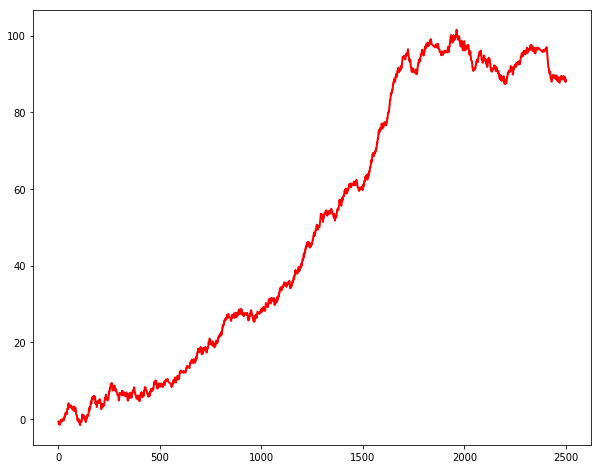

In [36]:
x=x=[i for i in range(len(yp))]
yp=yp[::-1]
y=[]
value=0
s=0
for i in yp:
    if(i>0):
        value=(0.5)
    elif(i<0):
        value=(-0.6)
    else:
        value=(-0.05)
    s+=value
    y.append(s)
fig = plt.figure()
fig.suptitle('Sentiment Analysis Curve')
plt.figure(figsize=(10,8))
plt.plot(x, y, c="r", linestyle = '-', linewidth = 2)
plt.show



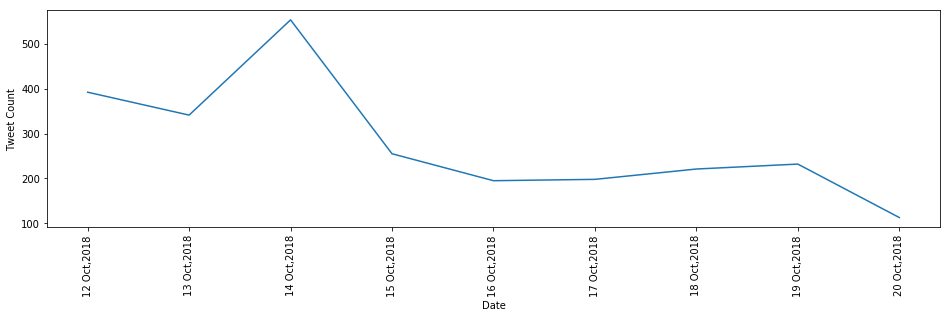

In [22]:
    df=pd.read_csv("disaster_tweets.csv",error_bad_lines=False)
    l=[]
    date_list=[]
    s=""
    #df['timestamp'][5].split()
    for ts in df['timestamp']:
        l=ts.split()
        s=l[2]+" "+l[1]+","+l[5]
        date_list.append(s)
    counter=collections.Counter(date_list)
    counter=collections.OrderedDict(sorted(counter.items()))
    fig = plt.figure()
    fig.suptitle('Tweet Counter')
    plt.figure(figsize=(16,4))
    plt.xticks(rotation=90)
    plt.plot(counter.keys(),counter.values())
    plt.xlabel('Date')
    plt.ylabel('Tweet Count')
    plt.show
    plt.savefig('No of tweets.jpg')
    

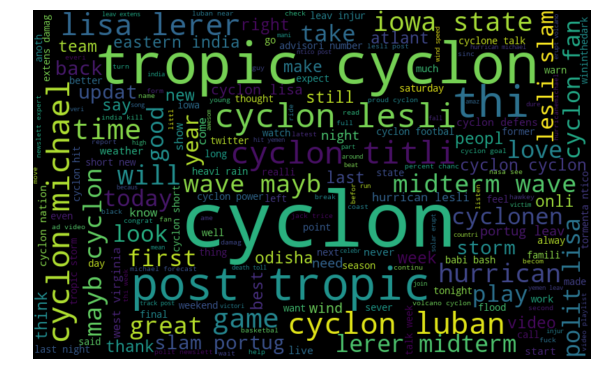

In [38]:
wordcloud()

Index([u'timestamp', u'location', u'text', u'coordinates', u'retweet'], dtype='object')
Total tweets: 2500
Total unique tweets: 2492


C:\Users\Shivam Budhia\Anaconda3\envs\python27\lib\site-packages\ipykernel_launcher.py:47: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


[('Cyclone', 1126), ('cyclone', 423), ('Leslie', 128), ('Post-Tropical', 127), ('Michael', 93), ('CYCLONE', 90), ('Tropical', 88), ('Iowa', 86), ('Titli', 86), ('tropical', 81)]


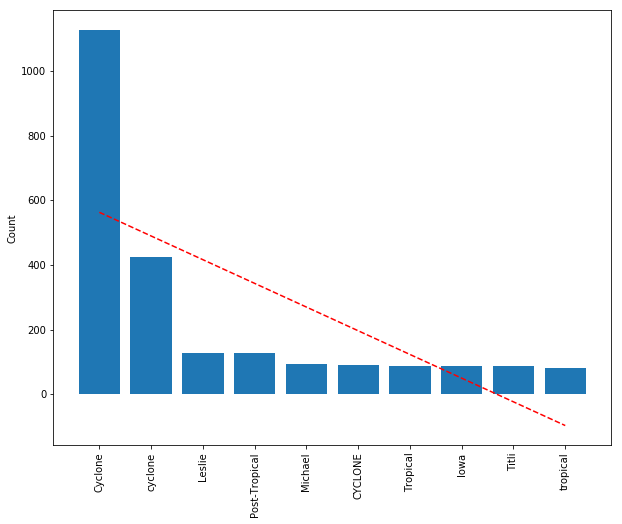

In [43]:
barplot()

C:\Users\Shivam Budhia\Anaconda3\envs\python27\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Shivam Budhia\Anaconda3\envs\python27\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


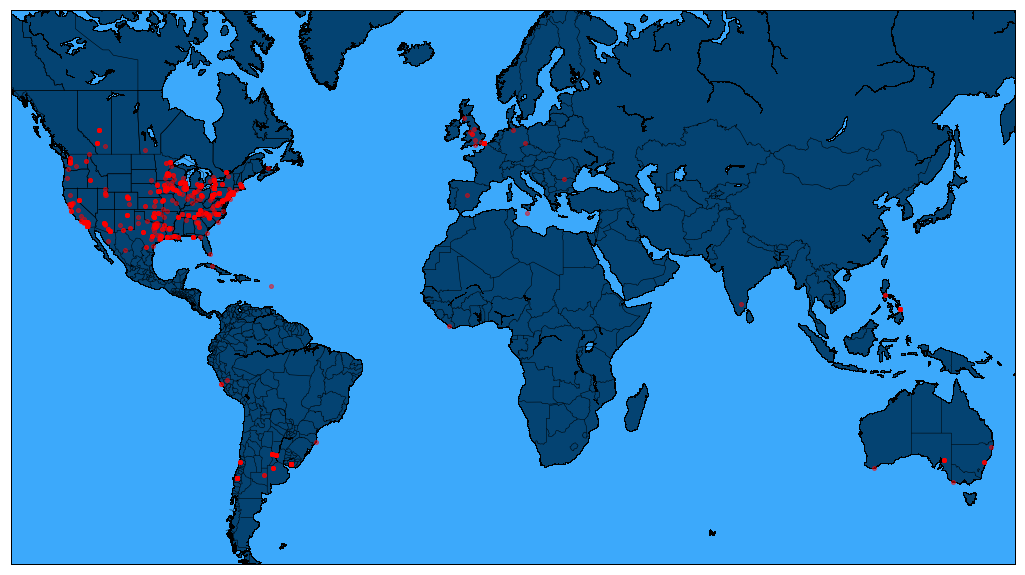

In [42]:
from mpl_toolkits.basemap import Basemap
plotting()

In [40]:
from textblob.classifiers import NaiveBayesClassifier
classifier()


Accuracy= 75.0472589792 %

=====================RELEVANT TWEETS========================

1 . Cyclone badtrip ka .. knabahan ako sau 

#oralreading 

2 . In light of the predicted result... Here is a great backgrounder on ‘the catalogue of own goals, blunders and bad m… https://t.co/PmCDH2M0Fv 

3 . @Alluvial_Amy @SEARGrhul @RHULEarthSci @Cyclone_Rocks There's a fine early digenetic history lurking in them! Also… https://t.co/Jw9CHY2U6M 

4 . @Iamtypalmer @cyclone_36 😂😂 

5 . @cyclone_36 Keep sleeping on them boys😂 

6 . #JanaSenaPorataYatra #JSPForNewAgePolitics 
#JSPStandsWithTitliVictims

👉Full reimbursement of farmers loan in cycl… https://t.co/TrH1IsI2uS 

7 . @LegendGoCrazy1 W 

8 . D2 Cyclones: CYCLONE GOAL! #D2Cyclones 

9 . @LegendGoCrazy1 🙋🏾‍♂️ 

10 . D2 Cyclones: Sweet moves man! CYCLONE GOAL! #D2Cyclones 

11 . @shofu Big Leff
Armada
2Saint 

12 . @shofu @LiquidChillin 

13 . D2 Cyclones: CYCLONE POWER PLAY GOAL! O’Connor from Ramsey with 6-and-change left in the first. #D2

90 . On a mission to catch a falling Cyclone in a Valkyrie or just shenanigans. Come join the fun! 

Going LIVE at 10PM… https://t.co/vTaqMnxFV8 

91 . @jon_greenberg Advantage, Cyclone. 

92 . @Raptor22d @NASA @NWSHuntsville @NASA_Marshall Trop Cyclone shown here starting@w.Coast Africa is several days into… https://t.co/tz8oHF6bRY 

93 . @blevins_bob @NASA @NWSHuntsville @NASA_Marshall Yes, a "small" cyclone still covers thousands of miles. That's a l… https://t.co/lEDCsFpEsy 

94 . Cyclone shuts Sembcorp Salalah water production plant DUBAI (Reuters) - Sembcorp Salalah Water and Power https://t.co/9GriLpQXz9 @ellieujn 

95 . ♫Cyclone - Baby Bash Ft. T-Pain 

96 . RESULT: Bantam - Fisher Conference Group B - Thu 7:15:  - Upper Canada Cyclone (2), Central Ontario Wolv (0) https://t.co/LOKaLvFmUL 

97 . RESULT: Bantam - Fisher Conference Group B - Thu 7:15:  - Upper Canada Cyclone (2), Central Ontario Wolv (0) https://t.co/geNf3oVm0h 

98 . @NASA @NWSHuntsville @NASA_Marshall CanThe NA

169 . On Politics With Lisa Lerer: A Midterm Wave? Maybe It’s a ‘Cyclone’ In the On Politics newsletter, two experts (and… https://t.co/5EHktALUFH 

170 . On Politics With Lisa Lerer: A Midterm Wave? Maybe It’s a ‘Cyclone’ In the On Politics newsletter, two experts (and… https://t.co/PWG3XWGsc0 

171 . On Politics With Lisa Lerer: A Midterm Wave? Maybe It’s a ‘Cyclone’ In the On Politics newsletter, two experts (and… https://t.co/at2bpjFsKo 

172 . ¿#SabiasQue Ya hay audífonos sumergibles en agua?, conócelos 👉 https://t.co/IdoL9k6lpW #PerfectChoice #Cyclone https://t.co/beeSMLA9A3 

173 . *HURRICANE UPDATE* WHAT IS HAPPENING TO HAWAII?! 
CYCLONE TO FORM OFF US COAST?
 https://t.co/k4G0UnTYeT via @YouTube 

174 . *HURRICANE UPDATE* WHAT IS HAPPENING TO HAWAII?! CYCLONE TO FORM OFF US ... https://t.co/nV6tZnuIcI via @YouTube 

175 . #HURRICANEupdate WHAT IS going on in #HAWAII ?!#CYCLONE 2 FORM OFF #US #COAST? #HurricaneMICHAEL... https://t.co/3fQVttMSdO 

176 . Wednesday October 17 - NY

252 . A few members of our sales team are currently at @LeicaGeosystems HDSU learning the ins and outs of important 3D sc… https://t.co/wnOEcCw2vW 

253 . Big 12 punishes Iowa State following field storming after West Virginia upset https://t.co/4ttRALfDNB via @DMRegister 

254 . Big 12 punishes Iowa State following field storming after West Virginia upset https://t.co/tJpLIFrt5j via @DMRegister 

255 . @trzef hi 

256 . @DigiDriver Sauce 

257 . Cyclone Luban devastates Oman and Yemen – And this CAMEL is trying to swim out of the desert flooding #weather… https://t.co/z49KJQOwKm 

258 . Five Cyclone alums on NBA rosters to open the 2018-19 season. https://t.co/0MV4cm5E4I 

259 . Tropical cyclone formation chances continue to be increased across both the West and East Pacific during each of th… https://t.co/ZrvNFJMyFy 

260 . UN says cyclone hitting Yemen leaving 'extensive damage' The cyclone has injured 33 people and affected 2,000 famil… https://t.co/OCZLjcj8Gy 

261 . UN says cyclo

323 . NASA finds remnants of Tropical Cyclone Luban near Yemen/Oman border https://t.co/AfUkhVlyM6 

324 . NASA finds remnants of Tropical Cyclone Luban near Yemen/Oman border - +GENERAL PHYSICS LABORATORY (GPL)

Tropical… https://t.co/p8tSuYwdQz 

325 . @FatalityFalcon 66.6 

326 . NASA sees remnants of Post-Tropical Cyclone Leslie over Spain https://t.co/5SedItLTFZ 

327 . Having some hesitation about going out of the house on Friday.... what if there’s a Cyclone??Blizzard?? 😜 or sunshi… https://t.co/cNVj9Kf0X9 

328 . This week Cyclone Cinema presents “Mission: Impossible - Fallout!”

Cyclone Cinema is FREE and open to all ISU stud… https://t.co/ZycGW27Ywv 

329 . @leosdadd Always spinning !!! Pug Cyclone 

330 . @LegendGoCrazy1 Imagine being a white 4’11 obeej meej irl 

331 . BREAKING: A new Prime Minister is appointed to the internationally recognized government of #Yemen, Dr. Maeen Abdul… https://t.co/KfysK7C9dS 

332 . Terrible flooding in al-Mahra east of #Yemen on the border 

399 . Cyclone goal! Alcott from Azevedo. #CycloneHockey #WhateverItTakes #ISUvsLU 

400 . 70 advisories, 17 days as a warm-core cyclone, and thousands of miles of traveled with rare impacts to Portugal and… https://t.co/ok6HPkcnvS 

401 . Leslie, now a post-tropical cyclone, closes in on Portugal https://t.co/3QMD6OlRcG via @CBSNews 

402 . NW and Central Pacific Ocean- No Current Tropical Cyclone Warnings. Tropical Cyclone develop is not expected in the next 24 hours. 

403 . Atlantic- Post-Tropical Cyclone Leslie Makes Landfall in  Portugal https://t.co/VCB4QNG9JT 

404 . Cyclone Power Play! @LULionsHockey for a slashing minor. 7:15 remains in the second. 

405 . RF: A hurricane, typhoon, and cyclone are all the same kind of weather phenomenon, they just occur in different geo… https://t.co/NKCYrdnm34 

406 . RF: A hurricane, typhoon, and cyclone are all the same kind of weather phenomenon, they just occur in different geo… https://t.co/LwniMEZ2R3 

407 . RF: A hurricane, typhoon, an

569 . @Demize_Cyclone @Debo_m8 this is big facts 

570 . @ParallelPlu amazing 

571 . 5pm advisory: Post-Tropical Cyclone #Leslie has 70mph winds and a 984mb pressure. It has merged with a cold front a… https://t.co/tbnDmssqT4 

572 . Patnaik announces monetary relief for people hit by Cyclone Titli, floods https://t.co/U9wrOmrnaw 

573 . Patnaik announces monetary relief for people hit by Cyclone Titli, floods https://t.co/6C5ycpsnly… https://t.co/TFmnscrmjN 

574 . Tormenta en el Atlántico: Post-Tropical Cyclone Leslie Graphics más en: https://t.co/z5vjLAbeRj 

575 . Post-Tropical Cyclone Leslie Public Advisory Number 70 https://t.co/3zSMFP84a4 

576 . Post-Tropical Cyclone Leslie Forecast Advisory Number 70 https://t.co/JuFBL77ozK 

577 . Post-Tropical Cyclone Leslie Forecast Discussion Number 70 https://t.co/v5ONEYKnHe 

578 . Post-Tropical Cyclone Leslie Wind Speed Probabilities Number 70 https://t.co/gJze8SDHMa 

579 . Post-Tropical Cyclone Leslie Public Advisory Number 70 https:

649 . "12 Feared Dead in India Cyclone Shelter Swamped by Landslide" by THE ASSOCIATED PRESS via NYT https://t.co/rP0bjPGt5J 

650 . 12 killed, 4 missing after cave hideout crumbles in rockslide triggered by Cyclone Titli via @htTweets https://t.co/pYbb2ajeTv 

651 . NASA sees Tropical Cyclone Luban nearing Oman https://t.co/2HmnfNPkrj 

652 . (Hurricane Leslie may become post-tropical cyclone on Saturday: NHC) StockaWiki | Fast Breaking Financial News  

(… https://t.co/viHRq1GhuL 

653 . NASA sees Tropical Cyclone Luban nearing Oman https://t.co/YzdOXQbNAD https://t.co/Tch9QUQHqX 

654 . NASA sees Tropical Cyclone Luban nearing Oman https://t.co/Ixi0dTkqv3 

655 . Other continents like Asia and America face some desperate disasters like volcano eruption, hurricanes and cyclone… https://t.co/mk8GGjJb94 

656 . CNN 1:23am AT LEAST 17 PEOPLE KILLED IN HURRICANE MICHAEL. . Storm leaves US. East Coast as a post-tropical cyclone 

657 . Crazy! Now post-tropical cyclone #Michael headed towa

728 . @tomh1138 @Jake_Vos_ @WLCyclone @MLeigh4ISU I’ve subjected our newborn to 66-68 degrees so far. Allows me to put to… https://t.co/ueu7N9Gvie 

729 . Post-Tropical Cyclone Michael Forecast Discussion Number 23: Issued at 500 AM EDT Fri Oct 12 2018 https://t.co/VBMJfpDqLr 

730 . Post-Tropical Cyclone Michael Forecast Discussion Number 23 https://t.co/8w1Ujp5aVc 

731 . Hurricane Leslie right now forecasted to impact western Europe as a Post Tropical Cyclone.  #Leslie https://t.co/ro3Ebp2EBG 

732 . 🎥 » @CyclonesTV caught up with @tminatta to preview tonight's match vs. No. 18 West Virginia at the Cyclone Sports… https://t.co/pvoqxkJiHD 

733 . Post-Tropical Cyclone Michael Graphics: 5-Day Uncertainty Track last updated Fri, 12 Oct 2018 08:51:25 GMT 

 Wind… https://t.co/KN1yfxKAww 

734 . #Cyclone hits India at 125km/h speed, kills at least 8 https://t.co/klyHN44tvo via @YouTube 

735 . Game Day Cyclone Nation is hyped! 

736 . @Forbes @ForbesScience
The residents of Houston, Puer

798 . Post-Tropical Cyclone Michael Forecast Discussion Number 23 https://t.co/CA7uoyHy5c 

799 . Post-Tropical Cyclone Michael Forecast Advisory Number 23 https://t.co/6ZZCv0ymWx 

800 . Post-Tropical Cyclone Michael Forecast Advisory Number 23 https://t.co/3ULuEef339 

801 . Tormenta en el Atlántico: Summary for Post-Tropical Cyclone Michael (AT4/AL142018) más en: https://t.co/YsDI5v8gJo 

802 . Tormenta en el Atlántico: Post-Tropical Cyclone Michael Forecast Advisory Number 23 más en: https://t.co/K96pzyXkNp 

803 . Please Refer to official NWS products

500 AM EDT Fri Oct 12 2018

...MICHAEL BECOMES A STORM-FORCE POST-TROPICAL L… https://t.co/OdoTvLFHhG 

804 . Severe Cyclone Titli Hits Eastern India, Killing 2 People, Displacing 300,000 https://t.co/8XVxJKQLWb https://t.co/EdmYAqfBMG 

805 . Insurance News:Severe Cyclone Titli Hits Eastern India, Killing 2 People, Displacing 300,000 

806 . Severe Cyclone Titli Hits Eastern India, Killing 2 People, Displacing 300,000 A severe cycl

In [41]:
df=pd.read_csv('new_disaster_tweets.csv')
print df.head()

                        timestamp                 location  \
0  Sat Oct 20 11:24:54 +0000 2018            Nashville, TN   
1  Sat Oct 20 10:35:03 +0000 2018         Stamford, CT USA   
2  Sat Oct 20 10:00:48 +0000 2018                       US   
3  Sat Oct 20 09:55:39 +0000 2018           Sacramento, CA   
4  Sat Oct 20 09:54:45 +0000 2018  Southern California USA   

                                                text coordinates  retweet  \
0  @AllTogetherNows @KNP2BP @POTUS Really—would y...         NaN        0   
1  Green alert for tropical cyclone TWENTY-FOUR-E...         NaN        0   
2  CYCO Cyclone Rooting Gel Sachet 10 mL (10/Cs) ...         NaN        0   
3  @JLJeffLewis @Bravotv Flipping Out is the only...         NaN        0   
4  @OhioWxGirl Wow. Nice way to hallucinate an in...         NaN        0   

      Relevance  
0           NaN  
1  Not Relevant  
2  Not Relevant  
3  Not Relevant  
4  Not Relevant  
